# Application: Model selection on mouse neural crest and schwann cell dataset

In this notebook, we will use the `ModelComparison` class from `regvelo` to select an optimal model setup based on the real time and the stemness score. Using the best-performing model, we further perform a trajectory and latent time prediction. The dataset used in this notebook is a subset of the dataset used in [Kastriti, M. E. et al, 2022](https://doi.org/10.15252/embj.2021108780). It consists of Smart-seq2 single-cell transcriptomes from mouse cells spanning embryonic to adult stages and covering the full neural crest lineage, including Schwann cell precursors.

A detailed tutorial on how to use RegVelo's `ModelComparison` class is provided in the [Model Comparison Tutorial](https://regvelo.readthedocs.io/en/latest/tutorials/modelcomparison/ModelComp.html).

## Library import

In [1]:
import numpy as np
import scanpy as sc
import cellrank as cr
import scvi
import scvelo as scv

import regvelo as rgv
from regvelo import REGVELOVI
from regvelo import ModelComparison 

## General settings and function definition

In [2]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


In [3]:
scv.settings.set_figure_params("scvelo", dpi=80, transparent=True, fontsize=14, color_map="viridis")

In [4]:
%matplotlib inline

In [5]:
def min_max_scaling(data):
    """Compute min and max values for each feature."""
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)

    # Perform min-max scaling
    scaled_data = (data - min_vals) / (max_vals - min_vals)

    return scaled_data

## Load data

In the following, we load the preprocessed mouse neural crest dataset and define the true developmental time and save it to `adata.obs["devtime"]`.

In [6]:
adata = rgv.datasets.schwann()

100%|██████████| 362M/362M [00:02<00:00, 127MB/s]  


In [7]:
## convert developmental time as integer values
mapping = {
    "E9.5": 0, "E10.5": 1, "E11.5": 2, "E12.5": 3, "E13.5": 4,
    "E14.5": 5, "E16.5": 6, "E18.5": 7, "P0": 8, "P2": 9,
    "P6": 10, "P10": 11, "Adult": 12
}

adata.obs["devtime"] = adata.obs["devtime"].astype(str).replace(mapping).astype(np.float32)

In [8]:
adata

AnnData object with n_obs × n_vars = 8821 × 1150
    obs: 'plates', 'devtime', 'location', 'n_genes_by_counts', 'total_counts', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'leiden', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'TF', 'means', 'dispersions', 'dispersions_norm', 'velocity_genes'
    uns: 'assignments_colors', 'devtime_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'location_colors', 'log1p', 'neighbors', 'network', 'paga', 'regulators', 'skeleton', 'targets', 'umap'
    obsm: 'X_diff', 'X_pca', 'X_umap'
    layers: 'GEX', 'Ms', 'M

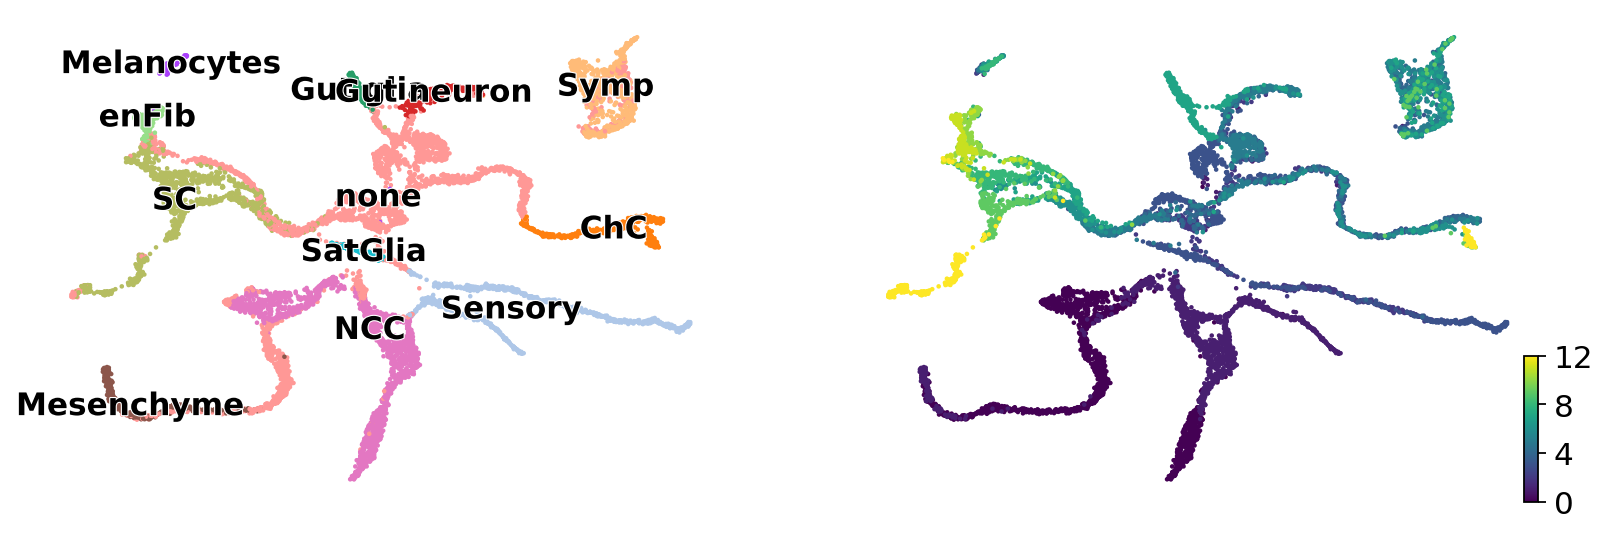

In [9]:
scv.pl.scatter(adata, basis="umap", title="", color=["assignments","devtime"], legend_loc="on data")

## ModelComparison

### Object initialization
We now initialize the `ModelComparison` object.

In [10]:
comp = ModelComparison()

### Train
We set `batch_size` to `np.min(adata.shape[0], 5000)` to avoid out of memory issue.

In [11]:
comp.train(adata=adata, 
           model_list=['soft','hard','soft_regularized'],
           lam2=[1.0],
           n_repeat=1, 
           batch_size=min(adata.shape[0], 5000))

[rank: 0] Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo_env/lib/python3.

Epoch 1369/1500:  91%|█████████▏| 1369/1500 [45:44<04:22,  2.01s/it, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -4881.255. Signaling Trainer to stop.


[rank: 0] Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connector

Epoch 1424/1500:  95%|█████████▍| 1424/1500 [46:44<02:29,  1.97s/it, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -4652.919. Signaling Trainer to stop.


[rank: 0] Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connector

Epoch 1050/1500:  70%|███████   | 1050/1500 [35:02<15:00,  2.00s/it, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -3928.337. Signaling Trainer to stop.


['soft_0', 'hard_0', 'soft_regularized\nlam2:1.0_0']

### Evaluate and save
We evaluate the model performance based on the real developmental time and how well the model preserves undifferentiated cell states.

In [12]:
# Based on real developmental time
comp.evaluate(side_information='Real_Time',
              side_key = 'devtime')

('df_Real_Time',
                         Model      Corr Run
 0                        soft  0.917364   0
 1                        hard  0.910931   0
 2  soft_regularized\nlam2:1.0  0.898595   0)

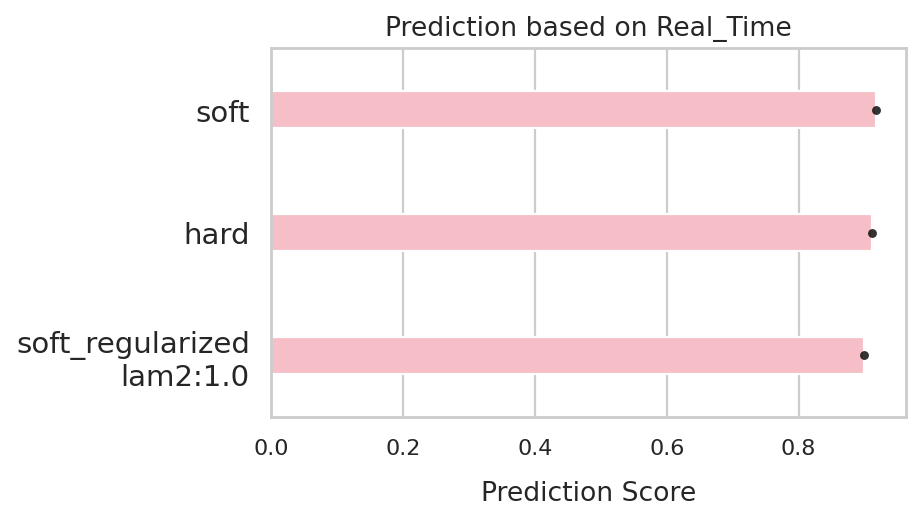

In [13]:
comp.plot_results(side_information='Real_Time')

In [14]:
# Based on stemness score
comp.evaluate(side_information='Stemness_Score',
              side_key='CytoTRACE')

('df_Stemness_Score',
                         Model      Corr Run
 0                        soft  0.964955   0
 1                        hard  0.960132   0
 2  soft_regularized\nlam2:1.0  0.948968   0)

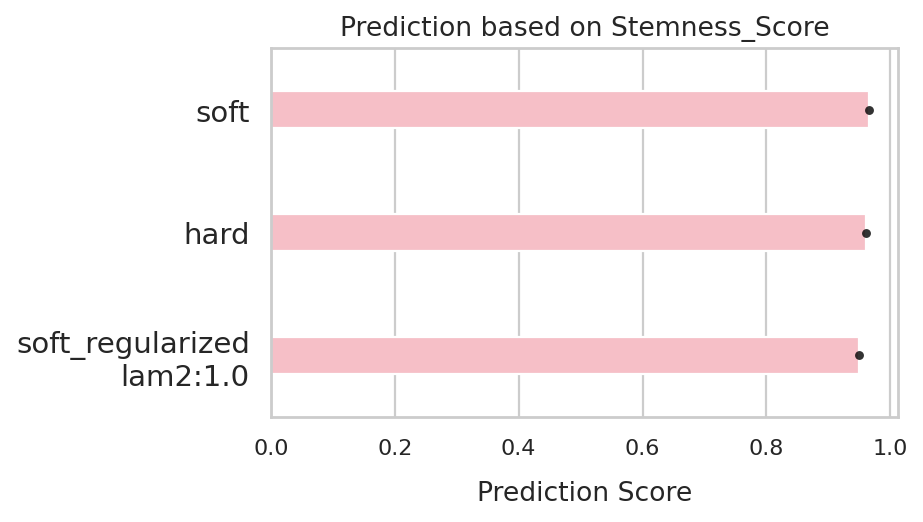

In [15]:
comp.plot_results(side_information='Stemness_Score')

In [16]:
comp.MODEL_TRAINED

REGVELOVI Model with the following params: 
n_hidden: 256, n_latent: 10, n_layers: 1, dropout_rate: 0.1
Training status: Trained

REGVELOVI Model with the following params: 
n_hidden: 256, n_latent: 10, n_layers: 1, dropout_rate: 0.1
Training status: Trained

REGVELOVI Model with the following params: 
n_hidden: 256, n_latent: 10, n_layers: 1, dropout_rate: 0.1
Training status: Trained

{'soft_0': , 'hard_0': , 'soft_regularized\nlam2:1.0_0': }

In [17]:
vae_s = comp.MODEL_TRAINED['soft_0']
vae_s.save('vae_s')

## Trajectory and latent time prediction

In [18]:
vae_s = REGVELOVI.load('vae_s', adata)
rgv.tl.set_output(adata, vae_s, n_samples=30, batch_size=5000)

INFO     File vae_s/model.pt already downloaded                                                                    


In [19]:
adata.obs["latent_time"] = min_max_scaling(adata.layers["fit_t"].mean(1))

In [23]:
scv.settings.set_figure_params("scvelo", dpi=80, transparent=True, fontsize=14, color_map="viridis")

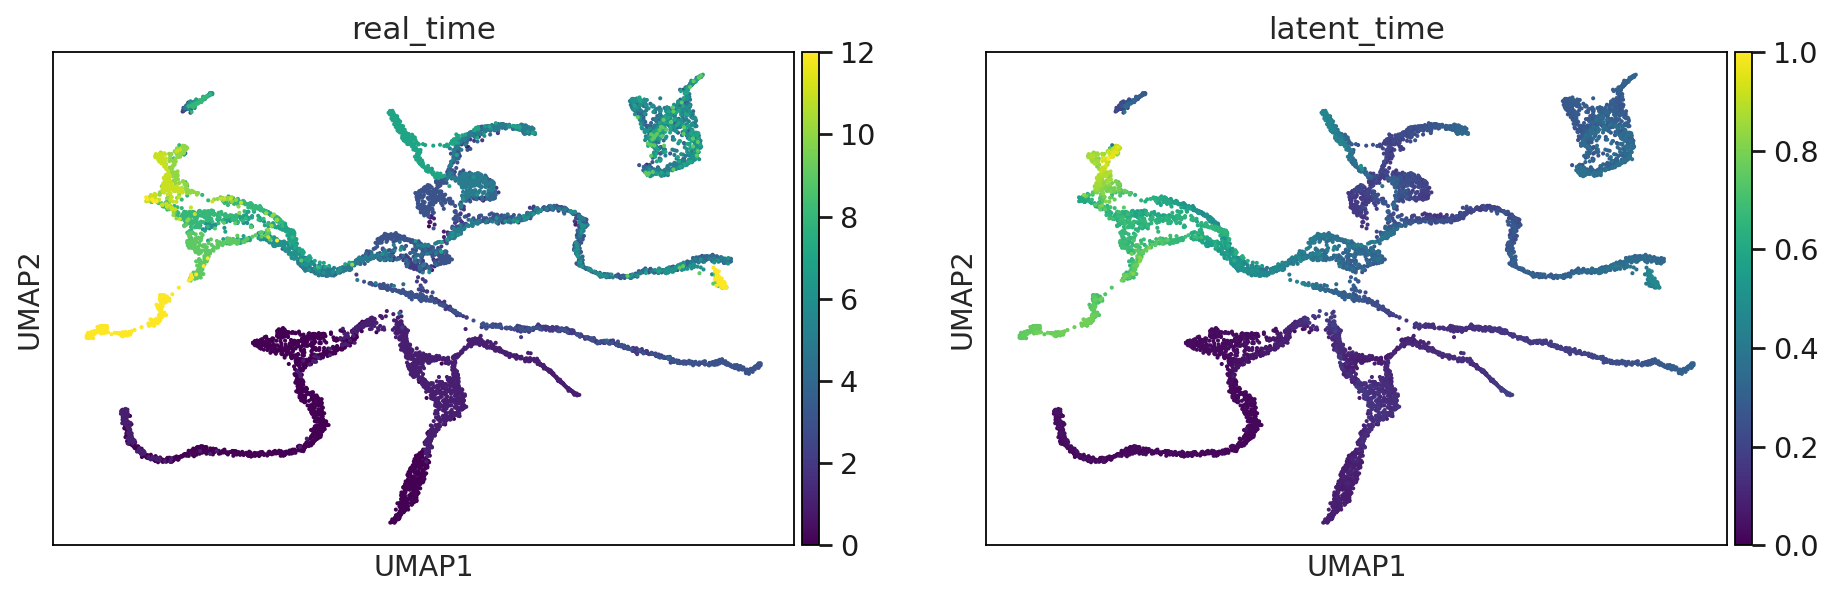

In [24]:
sc.pl.umap(adata, title=["real_time", "latent_time"],color = ["devtime", "latent_time"], legend_loc="on data")

In [25]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/128 cores)
    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


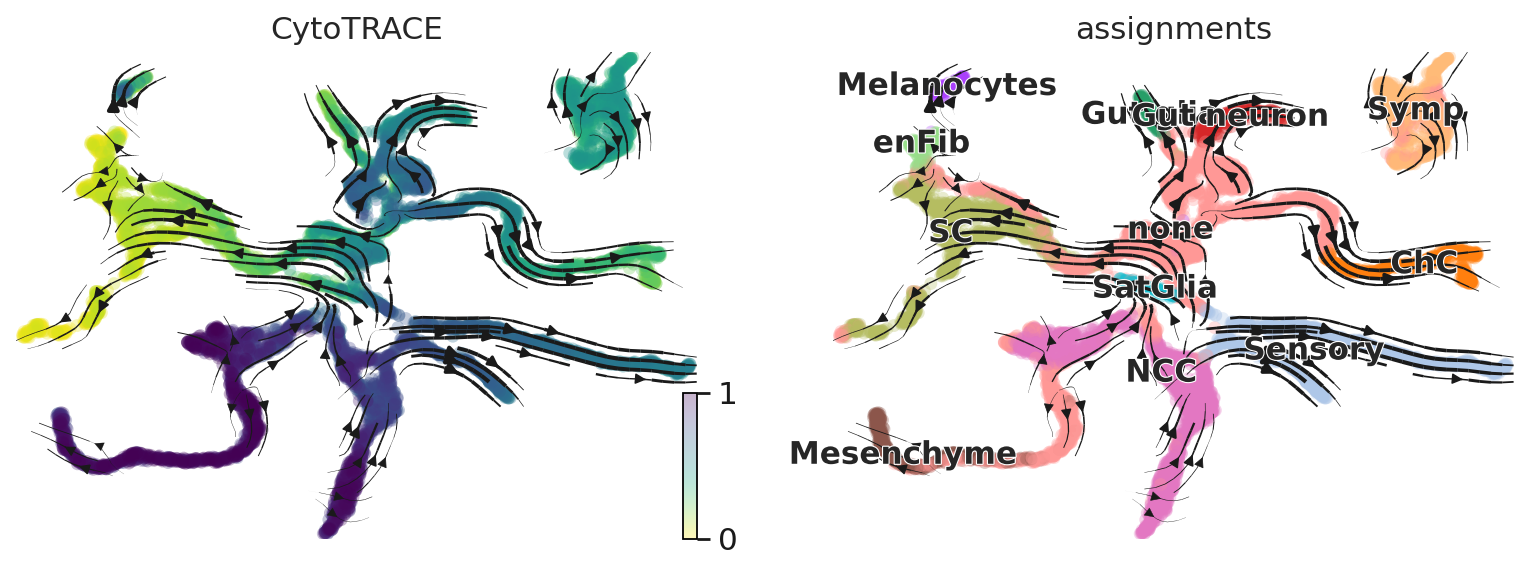

In [26]:
scv.pl.velocity_embedding_stream(adata, basis="umap", color=["CytoTRACE", "assignments"])